# Importar bibliotecas

In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np

from sklearn import linear_model as lm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Ler arquivos

In [2]:
train = pd.read_csv('Safra_2018-2019.csv')
test = pd.read_csv('Safra_2020.csv')

# Definir a coluna Unnamed como index

In [3]:
train = train.set_index('Unnamed: 0')

In [4]:
test = test.set_index('Unnamed: 0')

In [5]:
train.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
Unnamed: 0,,,,,,,,,,
0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,SCROP00005,342,1,0,1,0,0.0,0,2,1


# Verificando o tamanho de cada data set

In [6]:
train.shape, test.shape

((80000, 10), (8858, 9))

# Verificando os valores nulos do dados de treino

In [7]:
train.isnull().sum()

Identificador_Agricultor       0
Estimativa_de_Insetos          0
Tipo_de_Cultivo                0
Tipo_de_Solo                   0
Categoria_Pesticida            0
Doses_Semana                   0
Semanas_Utilizando          8055
Semanas_Sem_Uso                0
Temporada                      0
dano_na_plantacao              0
dtype: int64

# Resumo estatístico dos dados de treino

In [8]:
train.describe()

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,71945.000000,80000.000000,80000.000000,80000.000000
mean,1400.020875,0.283338,0.455550,2.267587,25.846750,28.664480,9.549088,1.897575,0.192312
std,849.792471,0.450622,0.498023,0.463748,15.557246,12.424751,9.905547,0.702079,0.455912
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [9]:
# Definindo todos valores nulos, da coluna Semanas_Utilizando, dos agricultores que nunca utilizaram pesticida, como 0
for idx, _ in train.iterrows():
    if train['Categoria_Pesticida'].at[idx] == 1:
        train['Semanas_Utilizando'].at[idx] = 0

In [10]:
# Poucos dados foram preenchidos
train.isnull().sum()

Identificador_Agricultor       0
Estimativa_de_Insetos          0
Tipo_de_Cultivo                0
Tipo_de_Solo                   0
Categoria_Pesticida            0
Doses_Semana                   0
Semanas_Utilizando          7967
Semanas_Sem_Uso                0
Temporada                      0
dano_na_plantacao              0
dtype: int64

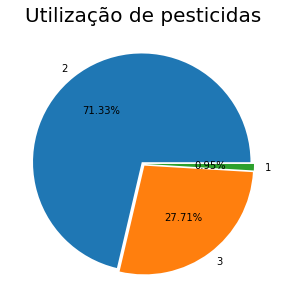

In [11]:
# O gráfico mostra que poucos agricultores nunca utilizaram pesticidas, o que explica porque tão poucos dados foram preenchidos
f, ax = plt.subplots(1,1,  figsize=(10,5))
train['Categoria_Pesticida'].value_counts().plot.pie(ax=ax, explode=[0.02,0.02,0.02], autopct='%0.2f%%')
ax.set_title('Utilização de pesticidas', fontsize=20)
ax.set_ylabel('')
plt.show()

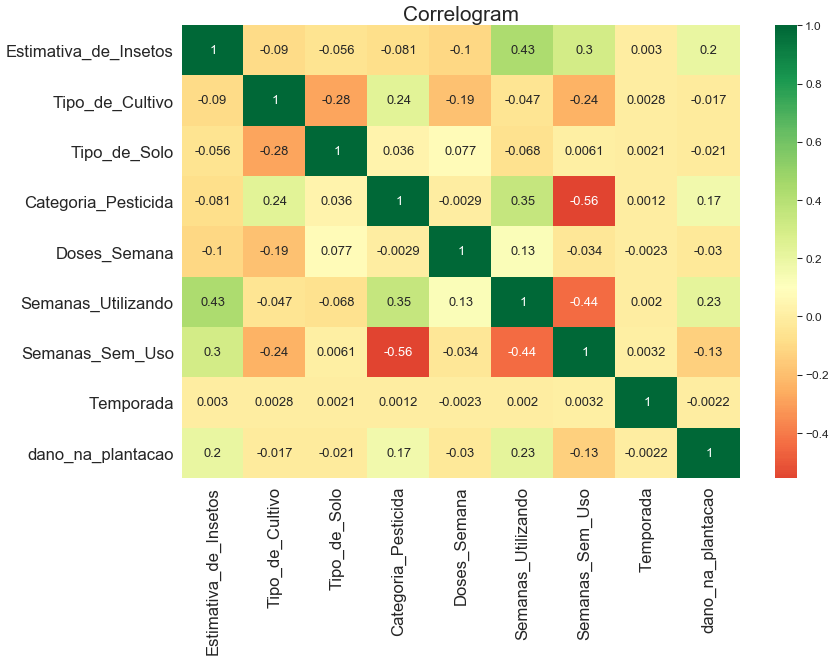

In [12]:
# Um heatmap com a correlação entre as variáveis para decidir qual delas seria a melhor alternativa
# para tentar "explicar" os valores da coluna Semanas_Utilizando
plt.figure(figsize=(15,10), dpi= 60)
sns.set(font_scale=1.3)
sns.heatmap(train.corr(), xticklabels=train.corr().columns, yticklabels=train.corr().columns, cmap='RdYlGn', center=.1, annot=True)

plt.title('Correlogram', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [13]:
# Escolhi a coluna Semanas_Sem_Uso, uma vez que existe uma correlação satisfatória e uma causalidade entre as duas colunas,
# uma vez que quanto maior o número de semanas utilizando, menos o número de semanas sem utilizar

In [14]:
data_train = train[['Semanas_Sem_Uso','Semanas_Utilizando']]

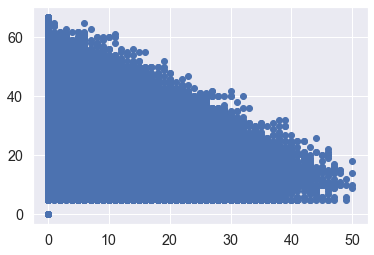

In [15]:
# Utilizei uma gráfico de dispersão para avaliar o comportamento dos dados. Após visualizar os dados, conclui que
# uma regressão linear seria uma boa alternativa para prever os dados que estavam faltando.
plt.scatter(data_train['Semanas_Sem_Uso'], data_train['Semanas_Utilizando'])

In [16]:
# Nota: Também optei por testar a utilização uma média simples dos valores da coluna Semanas_Utilizando, separando-as 
# pela coluna Categoria_Pesticida, o que me levou a um resultado não muito distante dos valores previstos pela regressão.
# A média de valores para agricultores que possuem classificação da coluna Categoria_Pesticida = 2, ou seja, que já utilizaram
# pesticidas, foi igual a 26.64 enquanto a dos que possuem classificação da coluna Categoria_Pesticida = 3, ou seja, que utiliza
# atualmente, foi igual a 34.83. No final optei pela utilização da regressão.

In [17]:
# Criei um novo data frame apenas com as duas colunas, filtrando para selecionar apenas os valores não nulos de agricultores
# que já utilizaram ou utilizam pesticidas
data_train = train[['Semanas_Sem_Uso', 'Semanas_Utilizando']].loc[train['Categoria_Pesticida'] > 1].dropna()

In [18]:
# Verifiquei se a filtragem havia ocorrido de maneira certa, verificando o número de linhas do novo data frame
data_train.shape

(71270, 2)

In [19]:
# Realizei o reshape das colunas para poder utilizar a regressão e atribui cada uma das colunas as variáveis.
# Instanciei o modelo e realizei o treinamento
x0 = np.array(data_train['Semanas_Sem_Uso']).reshape(-1, 1)
y0 = np.array(data_train['Semanas_Utilizando']).reshape(-1, 1) 

model_lm0 = lm.LinearRegression()


model_lm0.fit(x0, y0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Utilizei os parametros b0 e b1 para definir o coeficiente linear e angular da reta que melhor classifica meus dados
# y = b0 + b1 * x -> (y = 34.64943356 + -0.59272589 * x)
print(f" b1: {model_lm0.coef_}")
print(f" b0: {model_lm0.intercept_}")

 b1: [[-0.59272589]]
 b0: [34.64943356]


In [21]:
# Realizei a aplicação dos dados da coluna Semanas_Sem_Uso (X0) na minha equação da reta e obtive os valores de Y0
X0 = data_train['Semanas_Sem_Uso']
Y0 = -0.59272589*X0 + 34.64943356


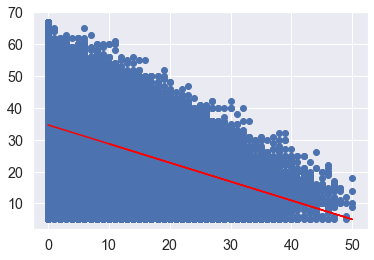

In [22]:
# Plotei a reta no meu grafico de disperção para confirmar os valores da reta
plt.scatter(data_train['Semanas_Sem_Uso'], data_train['Semanas_Utilizando'])
plt.plot(data_train['Semanas_Sem_Uso'], Y0, color = 'red')

In [23]:
# Alterei todos os dados nulos para um valor que não existisse préviamente em nenhuma das céluldas da coluna
train.fillna(99, inplace = True)

In [24]:
# Substituí os dados nulos pelo resultado de seus respectivos valores após a aplicação da equação obtida.
for idx, _ in train.iterrows():
    if train['Semanas_Utilizando'].at[idx] == 99:
        train['Semanas_Utilizando'].at[idx] = (-0.59272589*train['Semanas_Sem_Uso'].at[idx] + 34.64943356)

In [25]:
# Verifiquei que o index 35, que possuia um valor nulo, agora foi alterado de acordo com o desejado
train.iloc[35]

Identificador_Agricultor    SCROP00036
Estimativa_de_Insetos              257
Tipo_de_Cultivo                      0
Tipo_de_Solo                         0
Categoria_Pesticida                  3
Doses_Semana                        30
Semanas_Utilizando             34.6494
Semanas_Sem_Uso                      0
Temporada                            2
dano_na_plantacao                    0
Name: 35, dtype: object

In [26]:
# Realizei os mesmos passos citados acima, desta vez, para preencher os valores nulos dos dados de teste

In [27]:
test.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
Unnamed: 0,,,,,,,,,
80000,SCROP80001,256,0,1,2,35,11.0,9,1
80001,SCROP80002,283,0,1,2,5,5.0,6,1
80002,SCROP80003,283,0,1,2,15,15.0,5,2
80003,SCROP80004,283,0,1,2,15,NaN,7,2
80004,SCROP80005,283,0,1,2,15,19.0,2,1


In [28]:
test.isnull().sum()

Identificador_Agricultor      0
Estimativa_de_Insetos         0
Tipo_de_Cultivo               0
Tipo_de_Solo                  0
Categoria_Pesticida           0
Doses_Semana                  0
Semanas_Utilizando          945
Semanas_Sem_Uso               0
Temporada                     0
dtype: int64

In [29]:
for idx, _ in test.iterrows():
    if test['Categoria_Pesticida'].at[idx] == 1:
        test['Semanas_Utilizando'].at[idx] = 0

In [30]:
test.isnull().sum()

Identificador_Agricultor      0
Estimativa_de_Insetos         0
Tipo_de_Cultivo               0
Tipo_de_Solo                  0
Categoria_Pesticida           0
Doses_Semana                  0
Semanas_Utilizando          936
Semanas_Sem_Uso               0
Temporada                     0
dtype: int64

In [31]:
data_test = test[['Semanas_Sem_Uso', 'Semanas_Utilizando']].loc[test['Categoria_Pesticida'] > 1].dropna()

In [32]:
x1 = np.array(data_test['Semanas_Sem_Uso']).reshape(-1, 1)
y1 = np.array(data_test['Semanas_Utilizando']).reshape(-1, 1) 

model_lm1 = lm.LinearRegression()

model_lm1.fit(x1, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
print(f" b1: {model_lm1.coef_}")
print(f" b0: {model_lm1.intercept_}")

 b1: [[-0.59723425]]
 b0: [34.49360301]


In [34]:
# Nota os coefientes b1 e b0 mantiveram seus valores em relação aos dados de treino. Isso porque se tratam de dados dos mesmos
# agricultores com a diferença de que são de anos diferentes. Isso significa que não houve mudanças significativas
# nas duas colunas.

In [35]:
X1 = data_test['Semanas_Sem_Uso']
Y1 = -0.59272589*X1 + 34.64943356

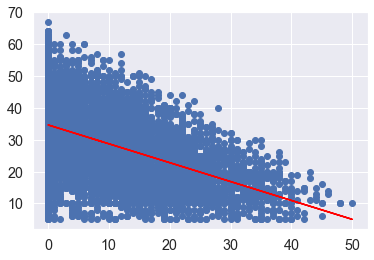

In [36]:
plt.scatter(data_test['Semanas_Sem_Uso'], data_test['Semanas_Utilizando'])
plt.plot(data_test['Semanas_Sem_Uso'], Y1, color = 'red')

In [37]:
test.fillna(99, inplace = True)

In [38]:
for idx, _ in test.iterrows():
    if test['Semanas_Utilizando'].at[idx] == 99:
        test['Semanas_Utilizando'].at[idx] = (-0.59272589*test['Semanas_Sem_Uso'].at[idx] + 34.64943356)

In [39]:
test.isnull().sum()

Identificador_Agricultor    0
Estimativa_de_Insetos       0
Tipo_de_Cultivo             0
Tipo_de_Solo                0
Categoria_Pesticida         0
Doses_Semana                0
Semanas_Utilizando          0
Semanas_Sem_Uso             0
Temporada                   0
dtype: int64

In [40]:
#  Por se tratar de um problema de classificação, optei por utilizar uma árvore de decisões.

In [41]:
X = train.drop(['dano_na_plantacao', 'Identificador_Agricultor'], axis = 1)

In [42]:
y = train['dano_na_plantacao']

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22)

In [44]:
x_train.shape, x_test.shape

((56000, 8), (24000, 8))

In [45]:
y_train.shape, y_test.shape

((56000,), (24000,))

In [46]:
clf = DecisionTreeClassifier()

In [47]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [48]:
clf.feature_importances_

array([0.26646477, 0.0203864 , 0.05410319, 0.06009842, 0.1182462 ,
       0.27082451, 0.11678866, 0.09308786])

In [49]:
# Através dos resultados, podemos perceber que as variáveis Estimativa_de_Insetos, Doses_Semana e Semanas_Sem_Uso
# são as mais relevantes para prever os danos causados ao solo.
for feature, importancia in zip(X.columns, clf.feature_importances_):
    print(f' {feature} , {importancia}')

 Estimativa_de_Insetos , 0.2664647678194195
 Tipo_de_Cultivo , 0.020386395619103794
 Tipo_de_Solo , 0.054103190975700995
 Categoria_Pesticida , 0.060098420726076476
 Doses_Semana , 0.11824619930513264
 Semanas_Utilizando , 0.2708245084023857
 Semanas_Sem_Uso , 0.11678866196325605
 Temporada , 0.09308785518892494


In [50]:
resultado = clf.predict(x_test)
resultado

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [51]:
# O modelo obteve bons resultados nas métricas de avaliação e com uma acurácia de 75%
print(metrics.classification_report(y_test, resultado))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     20029
           1       0.24      0.28      0.26      3319
           2       0.07      0.08      0.08       652

    accuracy                           0.75     24000
   macro avg       0.40      0.40      0.40     24000
weighted avg       0.76      0.75      0.75     24000



In [52]:
test = test.drop('Identificador_Agricultor', axis = 1)

In [53]:
# Aplicando o modelo aos dados de teste.
resultado2 = clf.predict(test)

In [54]:
resultado2.shape

(8858,)

In [55]:
resultado2

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [56]:
test['dano_na_plantacao'] = resultado2

In [57]:
test['dano_na_plantacao'].value_counts()

0    7274
1    1356
2     228
Name: dano_na_plantacao, dtype: int64

Text(0, 0.5, '')

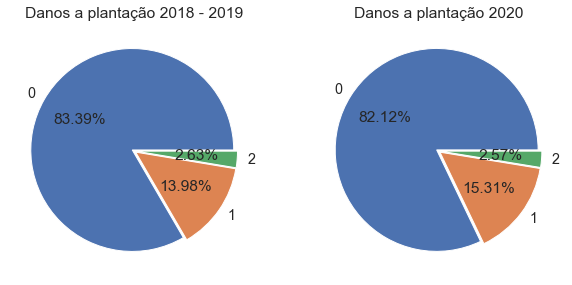

In [67]:
# Gráficos de setores comparando o os anos de 2018-2019 e 2020
f,ax=plt.subplots(1,2,figsize=(10,5))
train['dano_na_plantacao'].value_counts().plot.pie(explode=[0.02,0.02,0.02],autopct='%0.2f%%',ax=ax[0])
ax[0].set_title('Danos a plantação 2018 - 2019')
ax[0].set_ylabel('')
test['dano_na_plantacao'].value_counts().plot.pie(explode=[0.02,0.02,0.02],autopct='%0.2f%%',ax=ax[1])
ax[1].set_title('Danos a plantação 2020')
ax[1].set_ylabel('')

In [68]:
# Conclusão: Podemos notar um pequeno aumento nos danos causados por outros fatores que não os pesticidas. Podemos concluir que
# essa diferença se da por mudanças no tipo de cultivo e nas temporadas de plantação, Mas também existe, neste caso, 
# a possibilidade de que essa diferença foi causada pelo classificador, como dito anteriormente, ele obteve uma acurácia de 
# 75%, então é possível que tal diferença tenha sido causada por classificações equivocadas. Em todo caso, teremos a grande 
# maioria da da colheita(82,12%) sem danos à plantação, um dano considerável(15,31%) causados por outros fátores como o tipo
# de cultivo e as temporadas e um dano mínimo(2,57%) causado por pesticidas.